In [1]:
import hifive
import matplotlib.pyplot as plt
import numpy as np

# Working with HiC data

In [195]:
#Import HiC project
hic=hifive.HiC('/Users/cmdb/qbb2020-answers/week11/genome/project.hic', 'r')
data = hic.cis_heatmap('chr13', 1000000, datatype='fend', arraytype='full', diagonalincluded=True)
#Add pseudocount to avoid trouble with 0's
data +=1
#Calculate enrichment and log transform
enrichment = data[:,:,0]/data[:,:,1]
log_trans = np.log(enrichment)

Finding fend full array for chr13:1000000-120250001... Done


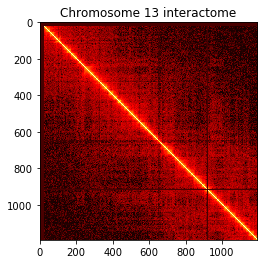

In [196]:
#Chromsome 13 heatmap using matplotlib
plt.imshow(log_trans, cmap='hot', interpolation='nearest')
plt.title('Chromosome 13 interactome')
plt.show()

# Compartment analysis

In [8]:
Comp = hifive.hic_domains.Compartment(hic, 100000, chroms=['chr13'], out_fname='tmp.hdf5')
Comp.write_eigen_scores('hic_comp.bed')

Finding expected full array for chr13:3000000-120300000... Done
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arr

In [9]:
X = Comp.positions['chr13']
Y = Comp.eigenv['chr13']

In [139]:
np.shape(X)

(1168, 2)

In [140]:
np.shape(Y)

(1168,)

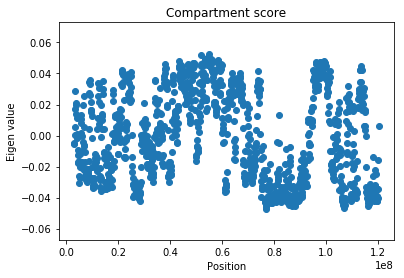

In [193]:
#Compartment score plot using start position vs eigen value from compartment analysis
plt.scatter(X[:, 0], Y)
plt.title('Compartment score')
plt.xlabel('Position')
plt.ylabel('Eigen value')
plt.show()

In [197]:
#Create dictionary with gene name as key and the start, end and FPKM as values
gene_data = open('./data/WT_fpkm.bed', 'r')
genes = {}
for line in gene_data:
    if 'chr13' not in line:
        continue
    else:
        lines = line.split('\t')
        name = lines[3]
        start = int(lines[1])
        end = int(lines[2])
        FPKM = float(lines[4])
        genes.setdefault(name, [start, end, FPKM])

In [22]:
#Import compartment HiC data and stoe start position, end position and value in list
hic_data = open('./hic_comp.bed', 'r')
hic_value = []
for line in hic_data:
    lines = line.rstrip().split('\t')
    start = int(lines[1])
    end = int(lines[2])
    value = float(lines[3])
    int_list = [start, end, value]
    hic_value.append(int_list)

In [62]:
#Create dictionary using gene names as keys and a list of all of the corresponding compartment values within that gene as values
gene_values = {}
for key, value in genes.items():
    for int_list in hic_value:
        if int_list[0] <= value[1] and int_list[1] >= value[0]:
            if key not in gene_values.keys():
                gene_values.setdefault(key, [int_list[2]])
            else:
                gene_values[key].append(int_list[2])
        elif int_list[1] >= value[0] and value[1] >= int_list[0]:
            if key not in gene_values.keys():
                gene_values.setdefault(key, [int_list[2]])
            else:
                gene_values[key].append(int_list[2])
        else:
            continue

In [65]:
#Create two separte lists for genes who have more positive values and for genes who have more negative values to separate out the compartments
positive = []
negative = []
for key, value in gene_values.items():
    neg_count = 0
    pos_count = 0
    for i in range(0, len(value)):
        if value[i] < 0:
            neg_count+=1
        elif value[i] > 0:
            pos_count+=1
    if pos_count > neg_count:
        positive.append(key)
    else:
        negative.append(key)

In [84]:
import math

In [89]:
#Create a dictionary using the positive compartment genes and store log2(FPKM + 1) for each gene
positive_exp = {}
for element in positive:
    if element in genes.keys():
        values = genes[element]
        exp = values[2]
        exp += 1
        log_trans = math.log(exp, 2)
        positive_exp.setdefault(element, log_trans)
        

In [91]:
#Create a dictionary using the negative compartment genes and store log2(FPKM + 1) for each gene
negative_exp = {}
for element in negative:
    if element in genes.keys():
        values = genes[element]
        exp = values[2]
        exp +=1
        log_trans = math.log(exp, 2)
        negative_exp.setdefault(element, log_trans)

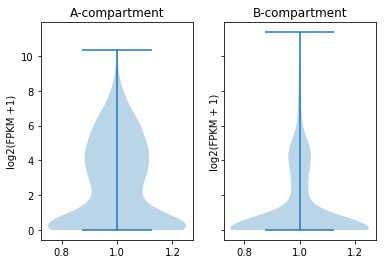

In [100]:
#Plot violinplots of gene expression in each of the compartments
fig, ax = plt.subplots(nrows =1, ncols=2, sharey = True)

ax[0].violinplot(positive_exp.values())
ax[0].set_title('A-compartment')
ax[0].set_ylabel('log2(FPKM +1)')
ax[1].violinplot(negative_exp.values())
ax[1].set_title('B-compartment')
ax[1].set_ylabel('log2(FPKM + 1)')
plt.show()

# Expression vs. Repression

In [157]:
#import H3K27me3 data and store it in a list with the gene name and FPKM value for A compartment genes
import pyBigWig
A_H3K = []
for key, value in positive_exp.items():
    if key in genes.keys():
        gene = key
        FPKM = genes[key][2]
        start = genes[key][0]
        end = genes[key][1]
        bw = pyBigWig.open('data/WT_H3K27me3.bw')
        H3K = bw.stats('chr13', start , end , type='sum')
        data = [gene, FPKM, H3K[0]]
        A_H3K.append(data)
        

In [158]:
#repeat for B compartment genes
B_H3K = []
for key, value in negative_exp.items():
    if key in genes.keys():
        gene = key
        FPKM = genes[key][2]
        start = genes[key][0]
        end = genes[key][1]
        bw = pyBigWig.open('data/WT_H3K27me3.bw')
        H3K = bw.stats('chr13', start , end , type='sum')
        data = [gene, FPKM, H3K[0]]
        B_H3K.append(data)

In [113]:
import pandas as pd

In [191]:
#Created dataframes so it would be easier to convert "None" values to 0 and transform the data to see what would look the best when plotting
df_A = pd.DataFrame(A_H3K, columns = ['gene', 'log2FPKM', 'H3K'])
df_A['H3K'] = df_A['H3K'].fillna(0)
df_A['log2H3K'] = np.log2(df_A['H3K'] + 1)

In [192]:
df_B = pd.DataFrame(B_H3K, columns = ['gene', 'log2FPKM', 'H3K'])
df_B['H3K'] = df_B['H3K'].fillna(0)
df_B['log2H3K'] = np.log2(df_B['H3K'] + 1)

In [187]:
#Removed outlier
x = df_B['log2FPKM']
removed_outlier = x.between(x.quantile(.05), x.quantile(.95))

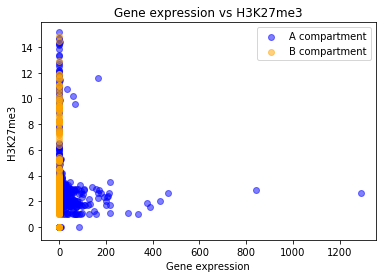

In [190]:
#Plotted gene expression vs H3K27me3 level 
plt.scatter(df_A['log2FPKM'], df_A['log2H3K'], c = 'blue', alpha = 0.5)
plt.ylabel('H3K27me3')
plt.xlabel('Gene expression')
plt.title('Gene expression vs H3K27me3')
plt.scatter(removed_outlier, df_B['log2H3K'], c = 'orange', alpha = 0.5)
plt.legend(['A compartment', 'B compartment'])
plt.show()